In [78]:
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import cv, XGBClassifier

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.io as pio
import plotly.offline as pyo
pio.renderers.default="notebook"

from datetime import date

# Warnings 
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
# pandas formatting
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("max_colwidth",200)
pd.set_option("display.colheader_justify", "center")
# Set notebook mode to work in offline
pyo.init_notebook_mode()

### Import data

In [4]:
df = pd.read_csv("../data/Bobs_df_delivery.csv")
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["pk_cid"] = df["pk_cid"].astype(int)

In [ ]:
#############################################################
def cat_uni_values(data):

    """ Prints the unique values for each categorical column in the provided DataFrame. """

    cat = data.select_dtypes(include = ["object"])
    for columns in cat:
        categories = data[columns].unique()
        print("[{}] has {} unique values\n".format(columns, categories))


#############################################################
def numerical(data):

    """ Prints the number of numerical features in a provided DataFrame, and the number of unique values for each one. """
   
    num = data.select_dtypes(include=["int16", "int32", "int64", "float16", "float32", "float64"]).columns
    print("The dataframe contains [{}] numerical features out of [{}] features:".format(len(num),data.shape[1]))
    
    for columns in num:
        categories = len(data[columns].unique())
        print("Column [{}] has [{}] unique values".format(columns, categories))

        
#############################################################
def missing_values (data):
        
        """ Returns a DataFrame showing the number and percentage of missing values for each column in the provided DataFrame. """
        
        missing_number = data.isnull().sum().sort_values(ascending=False)
        missing_percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100
        missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=["Missing_Number", "Percentage %"])
        return missing_values


#############################################################
def print_formatted_word(word):

    """ my 5 minutes of extreme sillyness """

    total_length = len("####################  SCORES & EVALUATIONS  #############################")
    word_length = len(word)
    num_of_hashes_before = len("####################  ")
    num_of_hashes_after = total_length - (num_of_hashes_before + word_length)
    print("#" * num_of_hashes_before + " " + word + " " + "#" * num_of_hashes_after)


##############################################################
def order_cluster(cluster_field_name, target_field_name, df, ascending):

    """
    Orders a DataFrame based on the mean of a target column for each value of a cluster column.

    Args:
        cluster_field_name (str): The name of the column containing the cluster values.
        target_field_name (str): The name of the column containing the target values to use for ordering.
        df (pandas.DataFrame): The DataFrame to be ordered.
        ascending (bool): Whether to sort the DataFrame in ascending order (True) or descending order (False).

    Returns:
        pandas.DataFrame: The ordered DataFrame with a new cluster column.
    """

    new_cluster_field_name = "new_" + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by = target_field_name,ascending = ascending).reset_index(drop=True)
    df_new["index"] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on = cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns = {"index": cluster_field_name})

    return df_final


##############################################################
def CLUSTER_maker(data, clusters, feature):

    """
    Uses K-means clustering to create a new column with cluster labels based on the values of a given feature.

    Args:
        data (pandas.DataFrame): The DataFrame containing the feature values to cluster.
        clusters (int): The number of clusters to create.
        feature (str): The name of the column containing the feature values to cluster.

    Returns:
        pandas.DataFrame: A DataFrame containing a new column with cluster labels based on the feature values.
    """

    data_ = data.copy(deep = True)
    kmeans = KMeans(n_clusters = clusters)
    kmeans.fit(data_[[feature]])
    data_[feature + "Cluster"] = kmeans.predict(data_[[feature]])

    return data_[[feature + "Cluster"]]


##############################################################
def product_summarizer(data):

    """
    Creates new columns in a DataFrame that summarize total values for different product categories.

    Args:
        data (pandas.DataFrame): The DataFrame to summarize.

    Returns:
        pandas.DataFrame: A copy of the input DataFrame with additional columns that summarize total values for different product categories.
    """
        
    data_ = data.copy(deep = True)
    Total_accounts = ["payroll", "payroll_account", "emc_account", "em_acount"]
    Total_loans = ["loans", "mortgage", "credit_card", "debit_card"]
    Total_funds = ["short_term_deposit", "funds", "securities", "long_term_deposit", "pension_plan"]

    data_["Total_funds"] = data_[Total_funds].sum(axis = 1)
    data_["Total_loans"] = data_[Total_loans].sum(axis = 1)
    data_["Total_accounts"] = data_[Total_accounts].sum(axis = 1)

    return data_


##############################################################
def RECENCY_maker(data, plot_1 = True, plot_2 = True):

    """
    Returns a dataframe with Recency and RecencyCluster columns for each customer.

    Args:
    data (pd.DataFrame): The input dataframe containing customer transaction data with pk_cid and pk_partition columns.
    plot_1 (bool): A boolean value indicating whether to plot the histogram of Recency or not. Default is True.
    plot_2 (bool): A boolean value indicating whether to plot the elbow plot of k-means clustering or not. Default is True.

    Returns:
    pd.DataFrame: A dataframe with Recency and RecencyCluster columns for each customer.
    """

    df_sorted = data.sort_values(["pk_cid", "pk_partition"])
    max_partition = df_sorted.groupby("pk_cid")["pk_partition"].max().reset_index()
    last_change = df_sorted.loc[df_sorted["Total_products"].diff() != 0].groupby("pk_cid")["pk_partition"].max().reset_index()
    last_change = pd.merge(max_partition, last_change, on = "pk_cid", how = "left")
    last_change["pk_partition"] = last_change["pk_partition_y"].fillna(last_change["pk_partition_x"])
    last_change.drop(["pk_partition_x", "pk_partition_y"], axis = 1, inplace = True)
    last_change.columns = ["CustomerID", "Last_Purchase"]

    df_date = data[["pk_cid","pk_partition"]]
    df_date.columns = ["CustomerID", "pk_partition"]

    last_change = pd.merge(last_change, df_date, on = "CustomerID", how = "left")
    last_change["Recency"] = (last_change["pk_partition"].max()- last_change["Last_Purchase"]).dt.days
    last_change.set_index("CustomerID", inplace = True)
    last_change.sort_values(by = "Recency", ascending = False, inplace = True)
    last_change.drop(["Last_Purchase", "pk_partition"], axis = 1, inplace = True)
    
    recency_df = pd.DataFrame(last_change.groupby("CustomerID")["Recency"].max()).reset_index()
    
    if plot_1:
        plt.hist(last_change["Recency"], bins = 10)

    if plot_2:
        SSE = {}
        for k in range(1, 10):
            kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(recency_df)
            SSE[k] = kmeans.inertia_ 
        plt.figure()
        plt.plot(list(SSE.keys()), list(SSE.values()))
        plt.xlabel("Number of cluster")
        plt.show()
    
    recency_df.sort_values(by = "Recency", ascending = True, inplace = True)
    recency_cluster_series = CLUSTER_maker(recency_df, 3, "Recency")
    
    recency_df = pd.concat([recency_df, recency_cluster_series], axis = 1)
    recency_df = order_cluster("RecencyCluster", "Recency", recency_df, False)
    display(recency_df.groupby("RecencyCluster")["Recency"].describe())
    recency_df.set_index("CustomerID", inplace = True)

    return recency_df


##############################################################
def RETENTION_values(data, plot_1 = True):

    """
    Returns a DataFrame with retention values and their respective clusters for each customer.
    
    Args:
        data (DataFrame): The input DataFrame containing customer data.
        plot_1 (bool, optional): Whether to plot a histogram of the retention values. Defaults to True.
    
    Returns:
        DataFrame: A DataFrame with retention values and their respective clusters for each customer.
    """

    data_ = data.copy(deep = True)
    df_retention = data_.groupby("pk_cid").pk_partition.count().reset_index()
    df_retention.columns = ["CustomerID","Retention"]

    if plot_1:
        plt.hist(df_retention.query("Retention < 1000")["Retention"], bins = 10)

    df_retention.sort_values(by = "Retention", ascending = True, inplace = True)
    retention_cluster_series = CLUSTER_maker(df_retention, 4, "Retention")

    df_retention = pd.concat([df_retention, retention_cluster_series], axis = 1)
    df_retention = order_cluster("RetentionCluster", "Retention", df_retention, True)
    display(df_retention.groupby("RetentionCluster")["Retention"].describe())
    df_retention.set_index("CustomerID", inplace = True)

    return df_retention


##############################################################
def FREQUENCY_values(data, plot = True):

    """
    Calculates the frequency of customer transactions using the provided data.

    Args:
        data (pandas.DataFrame): The input data containing customer transaction information.
        plot (bool, optional): A flag indicating whether to display a histogram of frequency. Default is True.

    Returns:
        pandas.DataFrame: A dataframe with CustomerID and Frequency columns, as well as cluster information.
    """
        

    data_ = data.copy(deep = True)
    PRODUCT_SUM = product_summarizer(data_)

    PRODUCT_SUM = PRODUCT_SUM[["pk_cid", "pk_partition", "entry_date", "Total_funds", "Total_loans", "Total_accounts"]]
    PRODUCT_SUM = PRODUCT_SUM.groupby("pk_cid").sum()
    store_ID = PRODUCT_SUM.groupby("pk_cid").sum().reset_index()
    
    frequency = PRODUCT_SUM.diff().fillna(0)
    frequency["Frequency"] = frequency.sum(axis = 1)
    
    frequency_df = pd.DataFrame(frequency["Frequency"])
    frequency_df.columns = ["Frequency"]
    if plot:
        freq = frequency["Frequency"][np.isfinite(frequency["Frequency"])]
        plt.hist(freq, bins=10)
        plt.show()

    frequency_df.reset_index(inplace = True)
    frequency_df.rename(columns = {"pk_cid": "CustomerID"}, inplace = True)
    frequency_df.sort_values(by = "Frequency", ascending = True, inplace = True)
    frequency_cluster_series = CLUSTER_maker(frequency_df, 4, "Frequency")

    frequency_df = pd.concat([frequency_df, frequency_cluster_series], axis = 1)
    frequency_df = order_cluster("FrequencyCluster", "Frequency", frequency_df, True)
    display(frequency_df.groupby("FrequencyCluster")["Frequency"].describe())
    frequency_df.set_index("CustomerID", inplace = True)

    return frequency_df


##############################################################
def REVENUE_values(data, plot = True):

    """
    Calculates the revenue generated by each customer and assigns them to a cluster based on their revenue. 

    Parameters:
    data (pd.DataFrame): Input data.
    plot (bool): Whether to plot a histogram of the frequency distribution of the revenue.

    Returns:
    pd.DataFrame: A dataframe with the customer IDs as the index and the revenue and revenue cluster as columns.
    """

    data_ = data.copy(deep = True)
    PRODUCT_SUM = product_summarizer(data_)
    PRODUCT_SUM["Revenue"] = (PRODUCT_SUM["Total_funds"] * 60 + 
                                PRODUCT_SUM["Total_loans"] * 40 + 
                                PRODUCT_SUM["Total_accounts"] * 10)
    REVENUE_SUM = PRODUCT_SUM.groupby("pk_cid")["Revenue"].sum().reset_index()

    REVENUE_SUM.sort_values(by = "Revenue", ascending = True, inplace = True)
    REVENUE_cluster_series = CLUSTER_maker(REVENUE_SUM, 4, "Revenue")

    REVENUE_SUM = pd.concat([REVENUE_SUM, REVENUE_cluster_series], axis = 1)
    REVENUE_SUM = order_cluster("RevenueCluster", "Revenue", REVENUE_SUM, True)
    display(REVENUE_SUM.groupby("RevenueCluster")["Revenue"].describe())
    REVENUE_SUM.rename(columns = {"pk_cid": "CustomerID"}, inplace = True)
    REVENUE_SUM.set_index("CustomerID", inplace = True)

    return REVENUE_SUM



##############################################################
def OVERALL_score_maker(RECENCY, RETENTION, FREQUENCY, REVENUE):
    
    """
    Combines the Recency, Retention, Frequency, and Revenue scores for each customer into a single Overall Score.
    
    Parameters:
        - RECENCY: A pandas DataFrame containing Recency scores for each customer
        - RETENTION: A pandas DataFrame containing Retention scores for each customer
        - FREQUENCY: A pandas DataFrame containing Frequency scores for each customer
        - REVENUE: A pandas DataFrame containing Revenue scores for each customer
        
    Returns:
        - SCORE_DF: A pandas DataFrame containing the Overall Score, as well as the individual Recency, Retention, Frequency, and Revenue scores for each customer.
    """
    
    SCORE_DF = pd.concat([RECENCY, RETENTION, FREQUENCY, REVENUE], axis = 1)
    SCORE_DF["OverallScore"] = (SCORE_DF["RecencyCluster"] + 
                                SCORE_DF["FrequencyCluster"] + 
                                SCORE_DF["RevenueCluster"] + 
                                SCORE_DF["RetentionCluster"])
    display(SCORE_DF.groupby("OverallScore")[["Recency", "Retention", "Frequency", "Revenue"]].mean())
    return SCORE_DF

In [5]:
products = ["short_term_deposit", "loans", "mortgage","funds", "securities", 
            "long_term_deposit", "credit_card", "debit_card","payroll", 
            "pension_plan", "payroll_account", "emc_account", "em_acount"]

## Products Segmentation


RFM stands for Recency, Frequency, and Monetary Value. It is a method used in customer segmentation and customer relationship management to analyze and categorize customers based on their transactional behavior.

The RFM method involves evaluating three key metrics for each customer:

Recency: How recently did the customer make a purchase? This metric measures the time elapsed since the customer"s last purchase.

Frequency: How frequently does the customer make purchases? This metric measures the total number of purchases made by the customer over a given time period.

Monetary Value: How much money has the customer spent on purchases? This metric measures the total amount of money spent by the customer over a given time period.

By analyzing these metrics for each customer, businesses can segment customers into different groups based on their transactional behavior. This allows businesses to develop targeted marketing and communication strategies that are tailored to the specific needs and preferences of each group. For example, customers who have made a recent, high-value purchase may be targeted with offers for related products or services, while customers who have not made a purchase in a long time may be targeted with incentives to return and make a purchase.

Overall, the RFM method is a powerful tool for businesses looking to improve customer engagement, retention, and revenue.

Create a DF to keep clustering scores

## **Calculate recency**

This code is calculating the recency metric for customer segmentation. It first sorts the by customer ID and transaction date, then finds the last date where the total number of products purchased by a customer was not equal to the previous value. It uses this date to calculate the recency metric, which is the number of days between the observation point (the maximum transaction date in the dataset) and the last purchase date for each customer. Finally, it plots a histogram of the recency values.

count     mean    std     min     25%     50%     75%   \
RecencyCluster                                                             
0               66317.000 472.015 31.792 365.000 485.000 485.000 485.000   
1              116867.000 252.854 55.305 151.000 212.000 273.000 304.000   
2              273189.000  12.731 30.454   0.000   0.000   0.000   0.000   

                  max   
RecencyCluster          
0              485.000  
1              334.000  
2              120.000

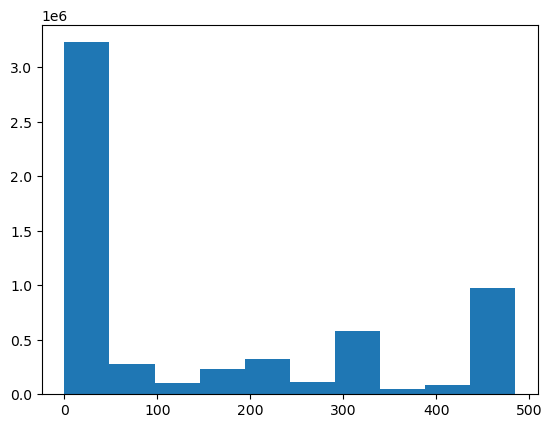

In [7]:
RECENCY_ALL= RECENCY_maker(df, True, False)

## **Calculate Retention**

This code calculates the retention rate for all customers based on their last purchase

count    mean    std   min    25%    50%    75%    max 
RetentionCluster                                                           
0                 33829.000  2.895 1.487  1.000  1.000  3.000  4.000  5.000
1                 73293.000  7.888 0.967  6.000  7.000  8.000  9.000  9.000
2                103943.000 10.975 0.569 10.000 11.000 11.000 11.000 13.000
3                245308.000 16.901 0.466 14.000 17.000 17.000 17.000 17.000

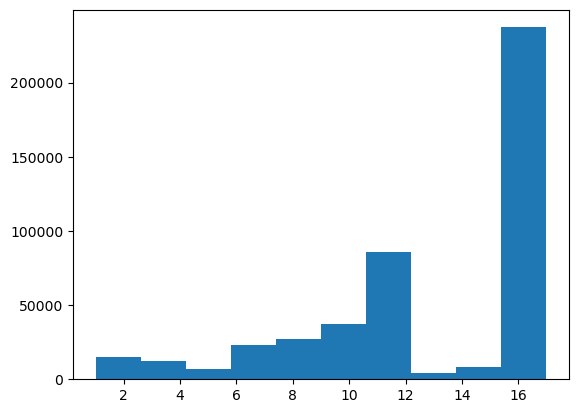

In [8]:
RETENTION_ALL = RETENTION_values(df, plot_1 = True)

## **Calculate Frequency**

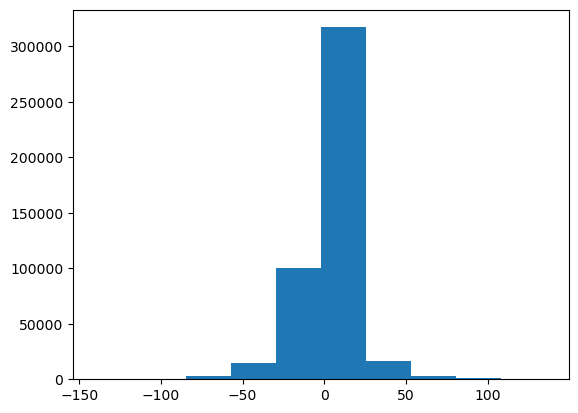

count     mean    std     min      25%     50%     75%   \
FrequencyCluster                                                              
0                 69079.000 -25.165 14.916 -140.000 -30.000 -17.000 -17.000   
1                302599.000  -0.523  3.659  -12.000   0.000   0.000   0.000   
2                 74269.000  17.845  6.597    9.000  14.000  17.000  19.000   
3                 10426.000  54.788 15.477   37.000  43.000  51.000  63.000   

                    max   
FrequencyCluster          
0                -13.000  
1                  8.000  
2                 36.000  
3                136.000

In [9]:
FREQUENCY_ALL = FREQUENCY_values(df)

The code is calculating the activation count for each product type (funds, loans, and accounts) for each customer, then summing them up to get the total frequency of activations for each customer.

A negative activation count means that the corresponding product was deactivated or cancelled by the customer. A zero activation count means that the customer did not activate or deactivate the product during the given time period. A positive activation count means that the customer activated a new product during the given time period.

### Frequency clusters

## **Calculate Revenue**

This code calculates the revenue for each customer

In [10]:
REVENUE_ALL = REVENUE_values(df, plot = True)

count     mean      std     min      25%      50%    \
RevenueCluster                                                          
0              194309.000   33.590  41.675    0.000    0.000    0.000   
1              217317.000  196.821  75.070  120.000  170.000  170.000   
2               34908.000  889.874 229.123  550.000  720.000  850.000   
3                9839.000 2035.272 477.368 1470.000 1690.000 1940.000   

                  75%      max    
RevenueCluster                    
0                80.000  110.000  
1               170.000  540.000  
2              1020.000 1460.000  
3              2220.000 5770.000

### Revenue Cluster

## **Overal Score**

In [11]:
SCORE_ALL = OVERALL_score_maker(RECENCY_ALL, RETENTION_ALL, FREQUENCY_ALL, REVENUE_ALL)

Recency  Retention  Frequency  Revenue
OverallScore                                        
0            435.459     4.054    -23.459     15.676
1            277.780     2.894    -22.461      8.018
2            227.658     4.646    -13.667     11.762
3            207.463     8.085    -11.608     19.289
4            155.993    10.141     -6.272     93.776
5            114.983    11.809     -1.018    109.900
6            361.825    15.943     10.290    240.437
7             31.100    16.822      1.266    233.584
8            122.339    16.427     15.745    733.806
9            107.785    16.787     27.197   1114.093
10           103.733    16.857     43.964   1626.690
11            41.683    16.947     58.967   2097.028

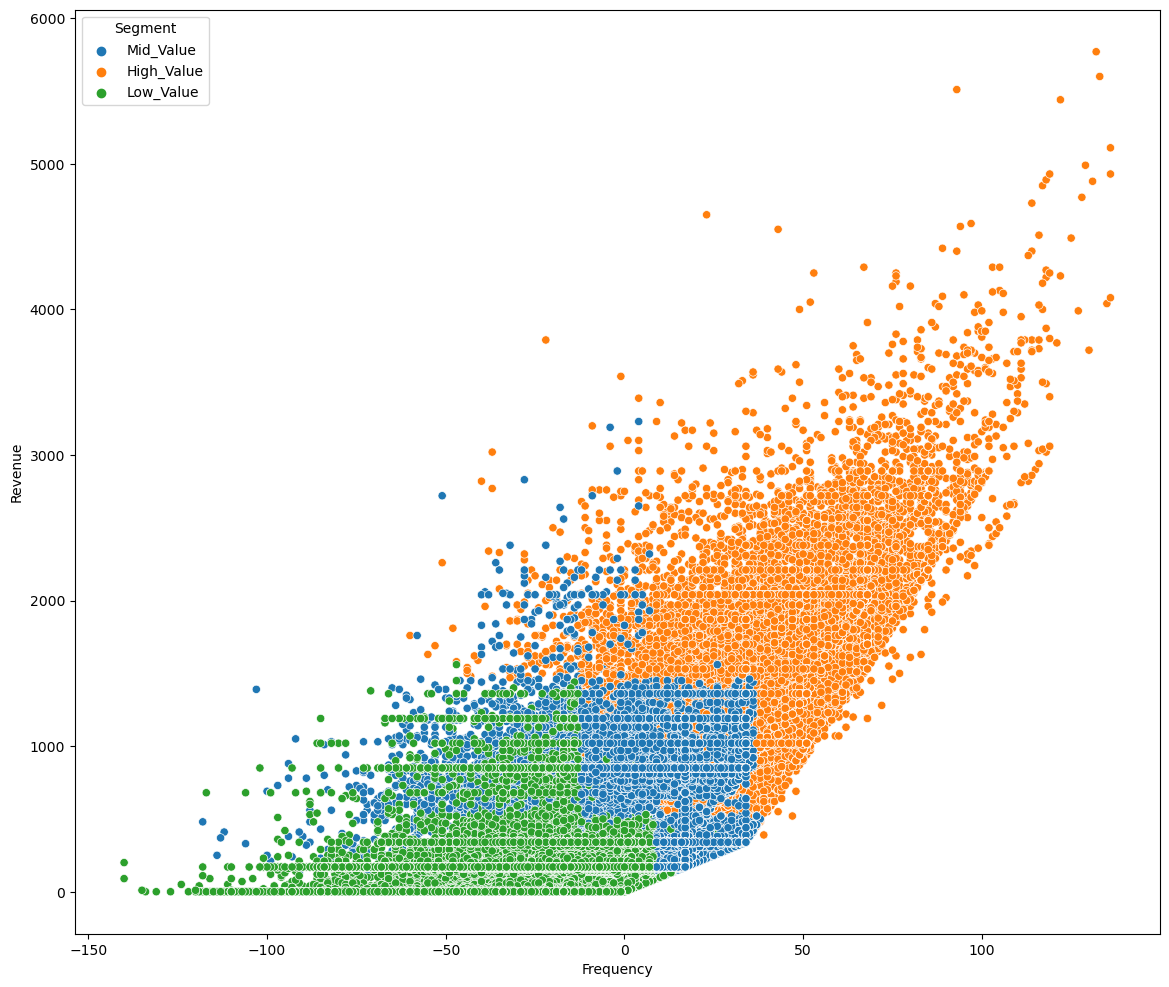

In [23]:
SCORE_ALL.loc[SCORE_ALL["OverallScore"] <= 5, "Segment"] = "Low_Value" 
SCORE_ALL.loc[SCORE_ALL["OverallScore"] > 5, "Segment"] = "Mid_Value" 
SCORE_ALL.loc[SCORE_ALL["OverallScore"] > 7, "Segment"] = "High_Value"

plt.figure(figsize = (14, 12))
sns.scatterplot(data = SCORE_ALL, x = "Frequency", y = "Revenue", hue = "Segment")
plt.xlabel("Frequency")
plt.ylabel("Revenue")
plt.show()

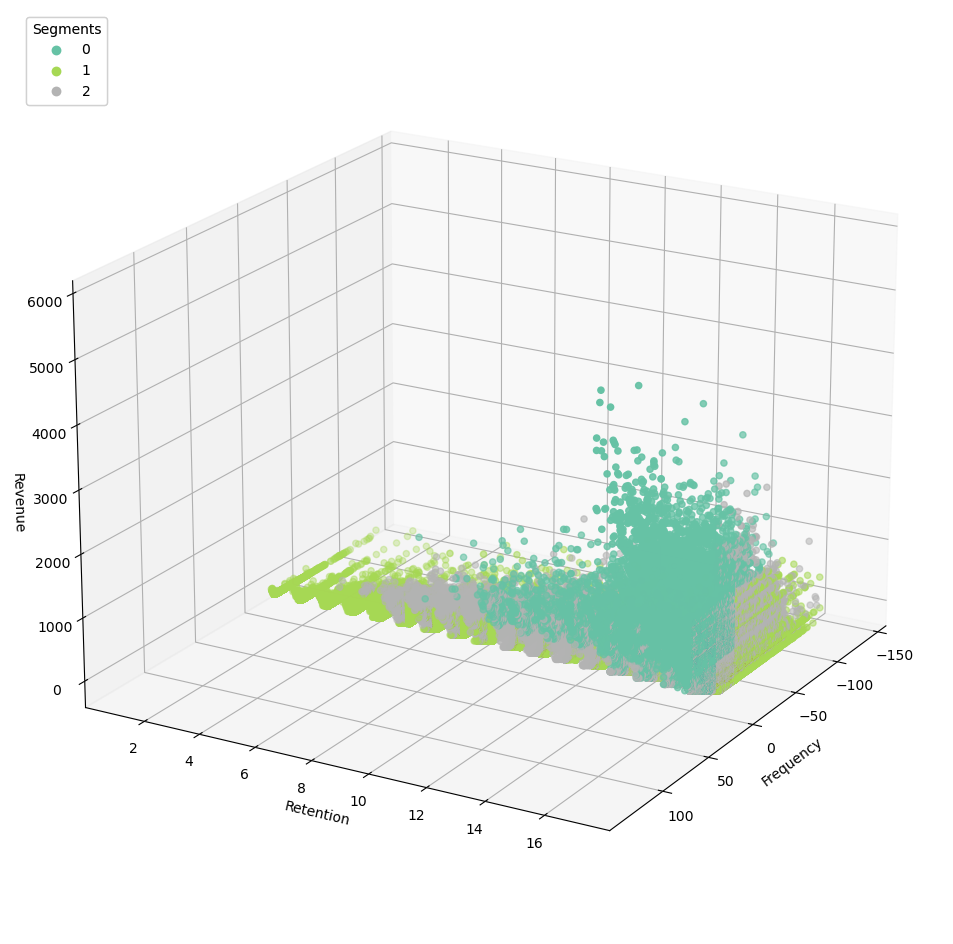

In [24]:
fig = plt.figure(figsize = (14 ,12))
ax = fig.add_subplot(111, projection = "3d")
scatter = ax.scatter(
    xs = SCORE_ALL["Frequency"],
    ys = SCORE_ALL["Retention"],
    zs = SCORE_ALL["Revenue"],
    c = SCORE_ALL["Segment"].astype("category").cat.codes,
    cmap = "Set2")

ax.set_xlabel("Frequency")
ax.set_ylabel("Retention")
ax.set_zlabel("Revenue")
legend = ax.legend(*scatter.legend_elements(), loc = "upper left", title = "Segments")
ax.add_artist(legend)
ax.view_init(elev = 20, azim = 30)
plt.show()

based on the overall score and the customer segment that we have identified, we can create targeted strategies for each segment:

**High Value Segment**: These are customers who have a high overall score, indicating that they are loyal, high-spending customers. The primary focus for this segment should be on improving retention, as these customers are valuable to the business.

**Mid Value Segment**: These customers have a moderate overall score, indicating that they have potential to become high-value customers but require more attention. The strategy for this segment should be to improve retention, as well as increase their frequency of purchases. 

**Low Value Segment**: These customers have a low overall score, indicating that they are infrequent purchasers and spend less than the other segments. The strategy for this segment should be to increase their frequency of purchases. By doing this, they can be converted into higher-value customers over time.

* High Value: Improve Retention
* Mid Value: Improve Retention + Increase Frequency
* Low Value: Increase Frequency




## Customer Life Time Value

LTV stands for "Lifetime Value". It is a term used in business and marketing to refer to the total amount of money that a customer is expected to spend on a company"s products or services over the course of their relationship with the company.

The LTV metric is important because it helps businesses determine the long-term profitability of a customer, and helps them make decisions about how much they are willing to spend on acquiring and retaining customers. To calculate LTV, businesses typically look at factors such as customer acquisition costs, customer retention rates, and average customer spending habits over time.

In essence, LTV is a measure of the total economic value of a customer to a business, and is a key metric used in customer relationship management and marketing strategies.

Life Time value perdiction:

* Define an appropriate time frame for Customer Lifetime Value calculation
* Identify the features we are going to use to predict future and create them
* Calculate lifetime value (LTV) for training the machine learning model
* Build and run the machine learning model
* Check if the model is useful

In [25]:
# create datetime objects
start_6m = pd.to_datetime(date(2018,1,28))
end_6m = pd.to_datetime(date(2018,6,28))
start_11m = pd.to_datetime(date(2018,6,28))
end_11m = pd.to_datetime(date(2019,5,28))

# create 6-month and 11-month dataframes

TEST_6M = df[(df.pk_partition < end_6m) & (df.pk_partition >= start_6m)].reset_index(drop=True)
TEST_11M = df[(df.pk_partition >= start_11m) & (df.pk_partition < end_11m)].reset_index(drop=True)

In [26]:
RECENCY_6M = RECENCY_maker(TEST_6M, False, False)
RETENTION_6M = RETENTION_values(TEST_6M, plot_1 = False)
FREQUENCY_6M = FREQUENCY_values(TEST_6M, plot = False)
REVENUE_6M = REVENUE_values(TEST_6M, plot = False)
SCORE_6M = OVERALL_score_maker(RECENCY_6M, RETENTION_6M, FREQUENCY_6M, REVENUE_6M)

SCORE_6M.loc[SCORE_6M["OverallScore"] <= 5, "Segment"] = "Low_Value" 
SCORE_6M.loc[SCORE_6M["OverallScore"] > 5, "Segment"] = "Mid_Value" 
SCORE_6M.loc[SCORE_6M["OverallScore"] > 7, "Segment"] = "High_Value"

count     mean    std    min     25%     50%     75%   \
RecencyCluster                                                            
0               50052.000 116.346  9.996 89.000 120.000 120.000 120.000   
1               16759.000  44.715 15.481 30.000  30.000  30.000  61.000   
2              185843.000   0.000  0.000  0.000   0.000   0.000   0.000   

                  max   
RecencyCluster          
0              120.000  
1               61.000  
2                0.000

count    mean   std   min   25%   50%   75%   max
RetentionCluster                                                     
0                  7419.000 1.499 0.500 1.000 1.000 1.000 2.000 2.000
1                  4110.000 3.000 0.000 3.000 3.000 3.000 3.000 3.000
2                  4413.000 4.000 0.000 4.000 4.000 4.000 4.000 4.000
3                236712.000 5.000 0.000 5.000 5.000 5.000 5.000 5.000

count     mean    std    min     25%     50%    75%   \
FrequencyCluster                                                           
0                 12761.000 -12.371 4.735 -39.000 -15.000 -11.000 -9.000   
1                206019.000  -0.453 1.466  -6.000   0.000   0.000  0.000   
2                 28243.000   5.595 2.228   3.000   4.000   5.000  7.000   
3                  5631.000  16.540 4.091  12.000  13.000  15.000 19.000   

                   max   
FrequencyCluster         
0                -7.000  
1                 2.000  
2                11.000  
3                38.000

count     mean     std     min     25%     50%     75%   \
RevenueCluster                                                              
0              213317.000  51.232  17.163   0.000  50.000  50.000  50.000   
1               23411.000 232.988  39.634 150.000 210.000 250.000 250.000   
2               10112.000 403.932  62.862 320.000 350.000 400.000 450.000   
3                5814.000 684.809 134.173 550.000 600.000 640.000 750.000   

                  max    
RevenueCluster           
0               140.000  
1               310.000  
2               540.000  
3              1700.000

Recency  Retention  Frequency  Revenue
OverallScore                                        
0            106.110    1.513     -12.412    11.591 
1             94.901    1.607      -5.594    12.122 
2             38.466    2.173      -4.951    34.973 
3             73.074    3.613      -7.550    40.643 
4            102.872    4.769      -3.813    62.384 
5             73.082    4.793       0.381   112.706 
6              6.101    4.995       0.174    63.408 
7             45.713    4.981       3.274   268.082 
8             34.294    4.995       5.679   367.111 
9             62.643    4.999      12.846   574.230 
10            21.195    4.999      14.589   621.719 
11             0.000    5.000      17.689   717.006

In [16]:
SCORE_6M.head()

Recency  RecencyCluster  Retention  RetentionCluster  Frequency  \
CustomerID                                                                    
1189599        0            2            5              3          0.000      
1224888        0            2            5              3          0.000      
1224889        0            2            5              3          0.000      
1224890        0            2            5              3          0.000      
1224891        0            2            5              3          0.000      

            FrequencyCluster  Revenue  RevenueCluster  OverallScore  Segment    
CustomerID                                                                      
1189599             1           50            0              6       Mid_Value  
1224888             1           50            0              6       Mid_Value  
1224889             1           50            0              6       Mid_Value  
1224890             1           50            0              6       Mid_Value  
1224891             1           50            0              6       Mid_Value

There is no cost specified in the dataset. That’s why Revenue becomes our LTV directly.

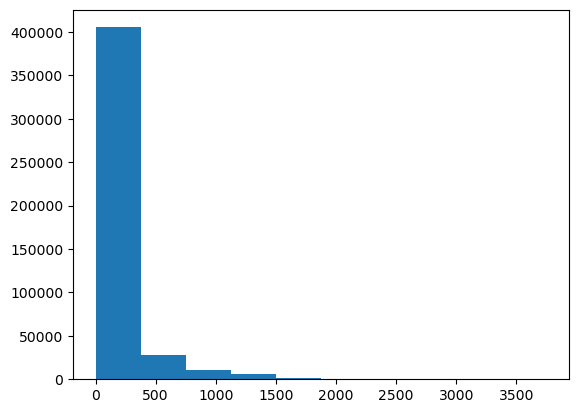

In [27]:
SCORE_11M = product_summarizer(TEST_11M)
SCORE_11M["Revenue"] = (SCORE_11M["Total_funds"] * 60 + 
                            SCORE_11M["Total_loans"] * 40 + 
                            SCORE_11M["Total_accounts"] * 10)

SCORE_11M = SCORE_11M.groupby("pk_cid")["Revenue"].sum().reset_index()
SCORE_11M.columns = ["CustomerID", "Revenue_11M"]

plt.hist(SCORE_11M["Revenue_11M"], bins = 10)
plt.show()

In [44]:
DF_18 = pd.merge(SCORE_6M, SCORE_11M, on = "CustomerID", how = "left")
DF_18 = DF_18.fillna(0)
print(DF_18.shape)
DF_18.head(5)

(252654, 12)


CustomerID  Recency  RecencyCluster  Retention  RetentionCluster  \
0    1189599      0            2            5              3          
1    1224888      0            2            5              3          
2    1224889      0            2            5              3          
3    1224890      0            2            5              3          
4    1224891      0            2            5              3          

   Frequency  FrequencyCluster  Revenue  RevenueCluster  OverallScore  \
0   0.000             1           50            0              6        
1   0.000             1           50            0              6        
2   0.000             1           50            0              6        
3   0.000             1           50            0              6        
4   0.000             1           50            0              6        

   Segment    Revenue_11M  
0  Mid_Value      110      
1  Mid_Value      110      
2  Mid_Value      110      
3  Mid_Value      110      
4  Mid_Value      110

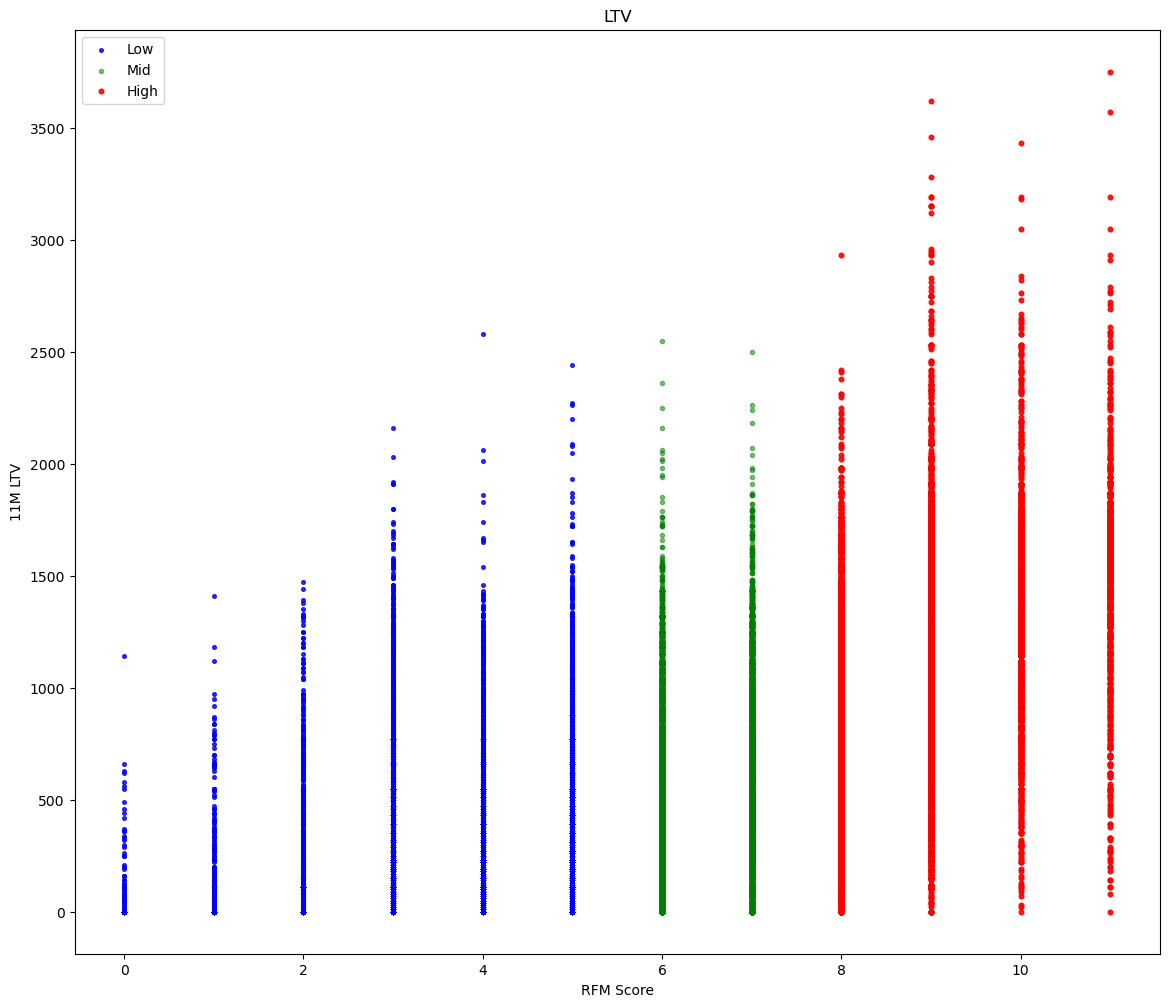

In [29]:
low_value = DF_18.query("Segment == 'Low_Value'")
mid_value = DF_18.query("Segment == 'Mid_Value'")
high_value = DF_18.query("Segment == 'High_Value'")

fig, ax = plt.subplots(figsize = (14, 12))

ax.scatter(
    low_value["OverallScore"], low_value["Revenue_11M"], s = 7, color = "blue", alpha = 0.8, label = "Low")
ax.scatter(
    mid_value["OverallScore"], mid_value["Revenue_11M"], s = 9, color = "green", alpha = 0.5, label = "Mid")
ax.scatter(
    high_value["OverallScore"], high_value["Revenue_11M"], s = 11, color = "red", alpha = 0.9, label = "High")

ax.set_xlabel("RFM Score")
ax.set_ylabel("11M LTV")
ax.set_title("LTV")
ax.legend()
plt.show()

Guidance reading the plot:

The LTV vs RFM plot can provide insights into the relationship between customer value and RFM scores, which are a measure of customer engagement and behavior. Here are a few things you might be able to learn from the plot:

High-value customers tend to have higher RFM scores than low-value customers. This is because high-value customers are typically more engaged and loyal, which is reflected in their RFM scores. You can see this trend in the plot by noting that the red points (representing high-value customers) tend to be clustered in the upper-right corner of the plot, where both RFM scores and LTV are high.

There may be a correlation between RFM scores and LTV. This is because RFM scores are based on customer behavior, and behavior can be a good indicator of future spending. You can look for evidence of this correlation in the plot by observing whether the scatter points are clustered along a diagonal line. If there is a strong positive correlation between RFM scores and LTV, you might expect to see a diagonal trend where the red points (representing high-value customers) are clustered in the upper-right corner of the plot, the green points (representing mid-value customers) are clustered in the middle, and the blue points (representing low-value customers) are clustered in the lower-left corner.

There may be outliers or anomalies in the data that warrant further investigation. For example, you might notice a low-value customer with a high LTV, or a high-value customer with a low LTV. These anomalies might be explained by factors such as seasonality, marketing campaigns, or changes in customer behavior over time. By identifying these anomalies, you can gain insights into how to optimize your marketing and customer retention strategies.

### LTV clusters

In [76]:
DF_CLUSTER = CLUSTER_maker(DF_18, 3, "Revenue_11M")
DF_CLUSTER = pd.concat([DF_CLUSTER, DF_18], axis = 1)
DF_CLUSTER.rename(columns = {"Revenue_11MCluster": "LTVCluster"}, inplace = True)
DF_CLUSTER = order_cluster("LTVCluster", "Revenue_11M", DF_CLUSTER, True)

DF_CLUSTER = DF_CLUSTER.copy()
DF_CLUSTER["CustomerID"] = DF_CLUSTER["CustomerID"].astype(int)

best_cust_list = DF_CLUSTER.query("LTVCluster==2")["CustomerID"].unique().tolist()
print(f"List Length: {len(best_cust_list)}")
display(DF_CLUSTER.groupby("LTVCluster")["Revenue_11M"].describe())

df_class = pd.get_dummies(DF_CLUSTER)
corr_matrix = df_class.corr()
pd.DataFrame(corr_matrix["LTVCluster"].sort_values(ascending = False))

List Length: 10234


count     mean      std     min     25%      50%      75%    \
LTVCluster                                                                  
0          210915.000  116.996  47.856   0.000  110.000  110.000  110.000   
1           31505.000  607.934 152.792 370.000  510.000  550.000  720.000   
2           10234.000 1357.540 305.010 990.000 1150.000 1310.000 1470.000   

              max    
LTVCluster           
0           360.000  
1           980.000  
2          3750.000

LTVCluster
LTVCluster             1.000  
Revenue_11M            0.943  
Revenue                0.794  
RevenueCluster         0.792  
Segment_High_Value     0.597  
FrequencyCluster       0.549  
Frequency              0.453  
OverallScore           0.383  
Recency                0.282  
Segment_Low_Value     -0.016  
CustomerID            -0.022  
Retention             -0.065  
RetentionCluster      -0.068  
Segment_Mid_Value     -0.294  
RecencyCluster        -0.305

 2 is the best whereas 0 is the worst.

In [77]:
TARGET = "LTVCluster"
X = df_class.drop([TARGET, "Revenue_11M"],axis=1)
y = df_class[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

split_data_dict = {
    "TRAINING": [X_train, y_train],
    "TESTING": [X_test, y_test]}

print("TARGET:", TARGET)
print("Train:", X_train.shape, "| Target Mean:", y_train.mean())
print("Test:", X_test.shape, "| Target Mean:", y_test.mean())

TARGET: LTVCluster
Train: (202123, 13) | Target Mean: 0.2057064262849849
Test: (50531, 13) | Target Mean: 0.20571530347707348


In [83]:
ltv_xgb_model = xgb.XGBClassifier(
    max_depth = 10, 
    learning_rate = 0.01,
    objective = "multi:softprob",
    n_jobs = -1).fit(X_train, y_train)

print("Accuracy of XGB classifier on training set: {:.2f}"
       .format(ltv_xgb_model.score(X_train, y_train)))
print("Accuracy of XGB classifier on test set: {:.2f}"
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred_prob = ltv_xgb_model.predict_proba(X_test[X_train.columns])
y_pred = ltv_xgb_model.predict(X_test)
df_test_prob = X_test.merge(pd.DataFrame(y_pred_prob, index=X_test.index), left_index=True, right_index=True)

df_test_prob["LTVCluster"] = y_test
df_test_prob["Predicted_Cluster"] = y_pred

print(classification_report(y_test, y_pred))
display(df_test_prob.head())

Accuracy of XGB classifier on training set: 0.93
Accuracy of XGB classifier on test set: 0.92
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     42183
           1       0.71      0.66      0.68      6301
           2       0.78      0.69      0.73      2047

    accuracy                           0.92     50531
   macro avg       0.81      0.77      0.79     50531
weighted avg       0.92      0.92      0.92     50531



CustomerID  Recency  RecencyCluster  Retention  RetentionCluster  \
170439    1021856      30           1            3              1          
76885     1300821       0           2            5              3          
217698    1254688      89           0            5              3          
182610    1166345     120           0            5              3          
78168     1284454       0           2            5              3          

        Frequency  FrequencyCluster  Revenue  RevenueCluster  OverallScore  \
170439    5.000            2           110           0              4        
76885     0.000            1            50           0              6        
217698    8.000            2           530           2              7        
182610   -5.000            1            50           0              4        
78168     0.000            1            50           0              6        

        Segment_High_Value  Segment_Low_Value  Segment_Mid_Value    0     1   \
170439           0                  1                  0         0.341 0.484   
76885            0                  0                  1         0.705 0.151   
217698           0                  0                  1         0.171 0.221   
182610           0                  1                  0         0.696 0.158   
78168            0                  0                  1         0.706 0.149   

          2   LTVCluster  Predicted_Cluster  
170439 0.176       0              1          
76885  0.144       0              0          
217698 0.608       2              2          
182610 0.146       0              0          
78168  0.144       0              0

In [82]:
y_pred_prob = ltv_xgb_model.predict_proba(X_test[X_train.columns])
y_pred = ltv_xgb_model.predict(X_test)

df_test_prob = X_test.merge(pd.DataFrame(y_pred_prob, index = X_test.index), left_index = True, right_index = True)
df_test_prob["LTVCluster"] = y_test
df_test_prob["Predicted_Cluster"] = y_pred
df_test_prob.groupby("LTVCluster")["Predicted_Cluster",0,1,2,].mean()

Predicted_Cluster    0     1     2 
LTVCluster                                     
0                0.030        0.681 0.171 0.148
1                0.765        0.340 0.455 0.205
2                1.628        0.208 0.313 0.479

In [97]:
EVA_DF = df[df["pk_cid"].isin(DF_CLUSTER.query("LTVCluster==2")["CustomerID"].tolist())]
EVA_DF = EVA_DF.query("active_customer==1")

BEST_PRODS = EVA_DF.reset_index().melt(id_vars = ["pk_partition", "pk_cid"], value_vars = products)
BEST_PRODS = BEST_PRODS[BEST_PRODS["value"] != 0]

BEST_2019 = EVA_DF[EVA_DF["pk_partition"] == EVA_DF["pk_partition"].max()]
BEST_2019 = BEST_2019["Total_products"].value_counts().to_frame().reset_index()
BEST_2019.columns = ["nr_products", "nr_customers"]
BEST_2019.sort_values("nr_products", ascending = True, inplace = True)
BEST_2019["pct_over_total"] = BEST_2019["nr_customers"] / BEST_2019["nr_customers"].sum()
BEST_2019

nr_products  nr_customers  pct_over_total
8       0             18          0.002     
6       1            114          0.011     
4       2            804          0.079     
2       3           1596          0.157     
0       4           4055          0.398     
1       5           2476          0.243     
3       6            916          0.090     
5       7            181          0.018     
7       8             29          0.003     
9       9              2          0.000